In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import healpy as hp
import cosmohmc.almncl.utils as utils
import cosmohmc.almncl.sampler as sampler
import matplotlib.pyplot as plt # For plotting

In [2]:
elmax = 32
nside = 32
el = np.arange(elmax+1)
Cl_th = 3*np.ones(elmax+1)
Cl_th[0:2] = 0

Text(0, 0.5, '$C_\\ell$')

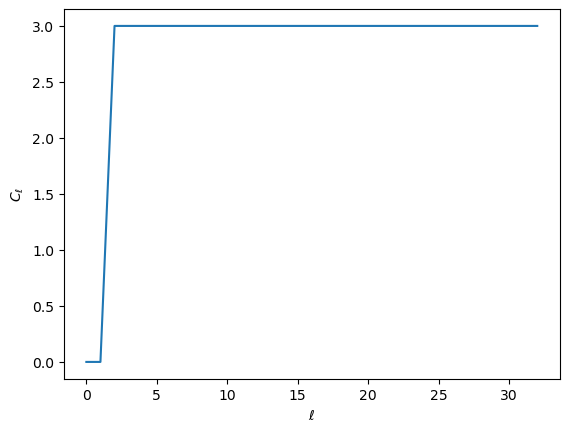

In [3]:
plt.plot(el, Cl_th, label='Theory')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')

In [4]:
#generate a signal realization for the given Cl; real space map and its harmonic coefficients
np.random.seed(10)
map_sig, alm_sig = hp.synfast(cls = Cl_th, nside = nside, lmax=elmax, mmax=elmax, alm=True,
    pol=False, pixwin=False, fwhm=0.0, sigma=None, new=False, verbose=True)

In [5]:
map_Cl = hp.anafast(map_sig, lmax=elmax, mmax = elmax, alm=False, pol=False)

In [6]:
#generate a noise realization, map as well as alms
np.random.seed(10)
sigma = 1.0
map_noise  = np.random.normal(0, sigma, hp.nside2npix(nside))

In [7]:
noise_var = sigma**2*np.ones(hp.nside2npix(nside))

In [8]:
#compute power spectra of noise realization
noise_Nl = np.ones(elmax+1) * (4*(np.pi)*(sigma**2))/(hp.nside2npix(nside))
noise_Nl[0:2] = 0
map_data = map_sig + map_noise

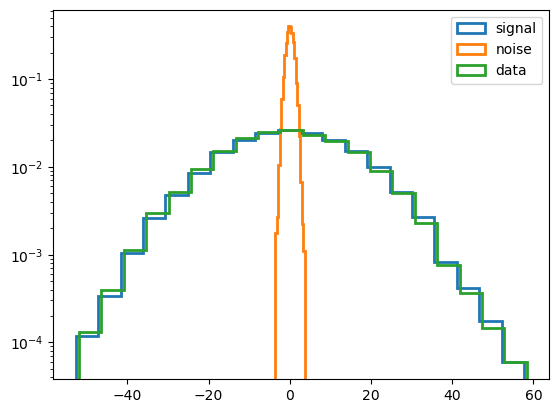

In [9]:
#compare data, signal and noise distribution
plt.hist(map_sig, histtype='step', bins=20, label = 'signal', density=True, lw = 2.0)
plt.hist(map_noise, histtype='step', bins=20, label = 'noise', density=True, lw = 2.0)
plt.hist(map_data, histtype='step', bins=20, label = 'data', density=True, lw = 2.0)
plt.legend(loc = 'upper right')
plt.yscale('log')

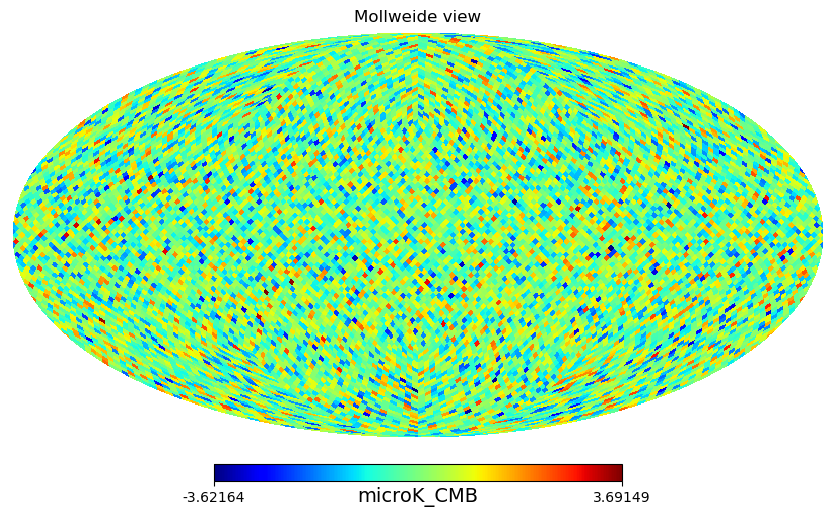

In [10]:
hp.mollview(map= map_noise,
            fig=None,
            rot=None, 
            coord=None, 
            unit=r'microK_CMB', 
            min=None, 
            max=None, 
            cbar=True, 
            cmap=plt.cm.jet, 
            notext=False, 
            norm=None, 
            hold=False, 
            margins=None, 
            sub=None, 
            return_projected_map=False)
#hp.graticule(dpar=30, dmer = 30, coord = 'G')
#plt.savefig('map_beta10_value10_lmax512_nside512_newbps_2nd.png')

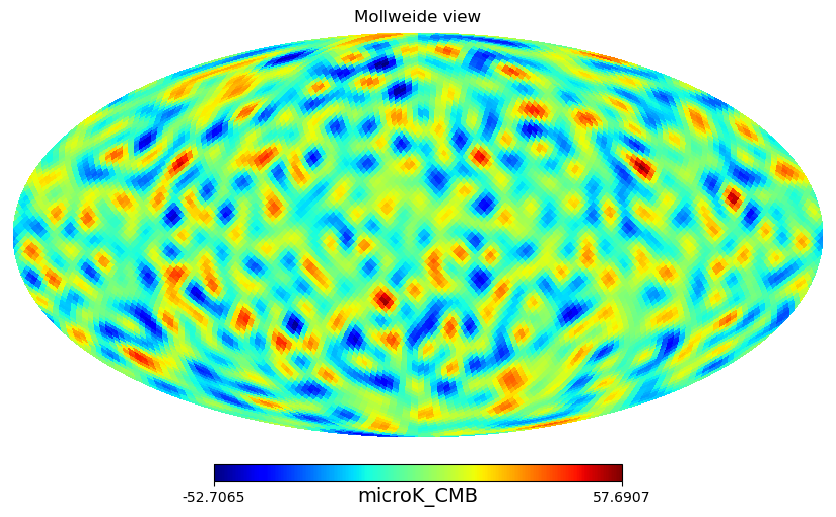

In [11]:
hp.mollview(map= map_sig,
            fig=None,
            rot=None, 
            coord=None, 
            unit=r'microK_CMB', 
            min=None, 
            max=None, 
            cbar=True, 
            cmap=plt.cm.jet, 
            notext=False, 
            norm=None, 
            hold=False, 
            margins=None, 
            sub=None, 
            return_projected_map=False)
#hp.graticule(dpar=30, dmer = 30, coord = 'G')
#plt.savefig('map_beta10_value10_lmax512_nside512_newbps_2nd.png')

In [12]:
#compute data angular power spectrum
data_cl = hp.anafast(map_data,lmax=elmax,alm=False,pol=False)

In [13]:
map_noise_Nl = data_cl-map_Cl
map_noise_Nl[:2] = 0

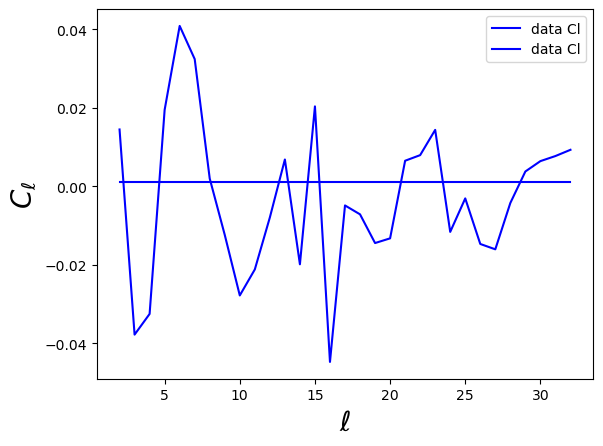

In [14]:
plt.plot(el[2:], data_cl[2:]-map_Cl[2:], color = 'b', label = 'data Cl')
plt.plot(el[2:], noise_Nl[2:], color = 'b', label = 'data Cl')
#plt.plot(el[2:], map_Cl[2:], 'k', label = 'map Cl')
#plt.plot(el[2:], Cl_th[2:], 'g', label = 'theory Cl')
#plt.plot(el[2:], Cl_th[2:] + np.sqrt(2)*Cl_th[2:]/np.sqrt(2*el[2:]+1), color = 'g', 
#         ls = '--', label = 'cosmic variance')
#plt.plot(el[2:], Cl_th[2:] - np.sqrt(2)*Cl_th[2:]/np.sqrt(2*el[2:]+1), color = 'g', 
#         ls = '--')
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)
plt.legend(loc = 'upper right')

In [15]:
hmc_sampler = sampler.almnclsampler_pix(data = map_data, elmax=elmax, nside=nside,noise_var=noise_var, Cl=Cl_th, Nl=noise_Nl, mask=None, step_size=0.1, n_steps=10, n_samples=100)

In [16]:
#np.random.seed(10)
sample_q_cl, sample_q_almr, sample_q_almi = hmc_sampler.HMCsample()

Sampling (HMC): 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


In [17]:
hmc_sampler.acceptance_rate

0.95

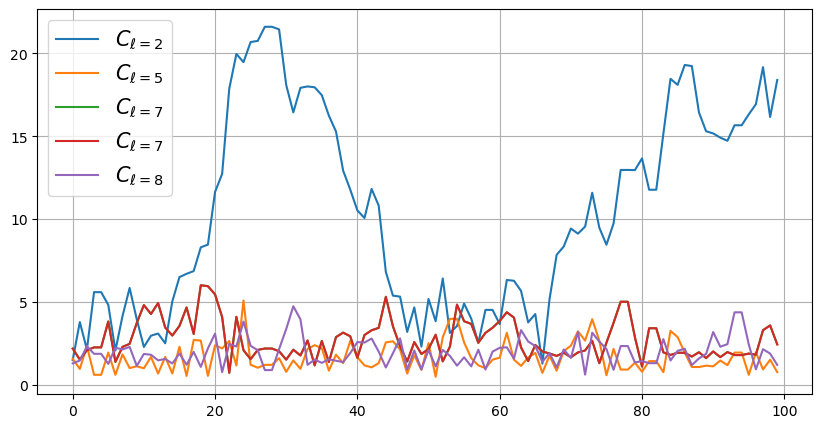

In [18]:
np.random.seed(10)
index = np.random.uniform(2, 10, 5)
plt.figure(figsize = (10, 5))
for j in np.sort(index): #np.arange(2, index, 1):
    i = int(j)
    plt.plot(sample_q_cl[:,i], label = r'$C_{\ell = %d}$' %(i))
plt.legend(loc = 'upper left', fontsize = 15)
plt.grid()

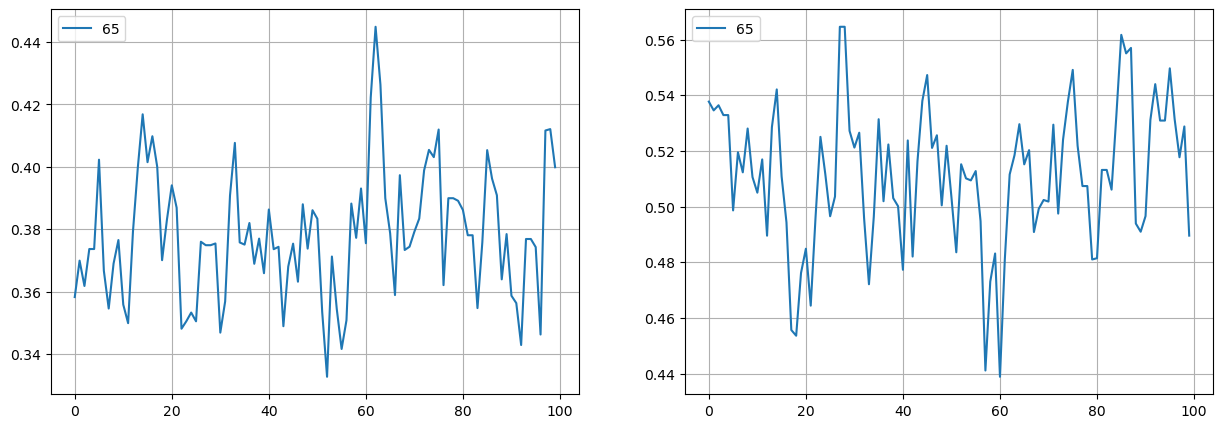

In [19]:
#inspect few chains of almr and almi
l = 10
m = 10
i = utils.lm2n_index(l = l, m = m)
plt.figure(figsize = (15, 5))
plt.subplot(121)
plt.plot(sample_q_almr[:,i], label = '%d' %(i))
plt.legend(loc = 'upper left')
plt.grid()
plt.subplot(122)
plt.plot(sample_q_almi[:,i], label = '%d' %(i))
plt.grid()
plt.legend(loc = 'upper left')

/Users/sayan/anaconda3/envs/hmc/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sayan/anaconda3/envs/hmc/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


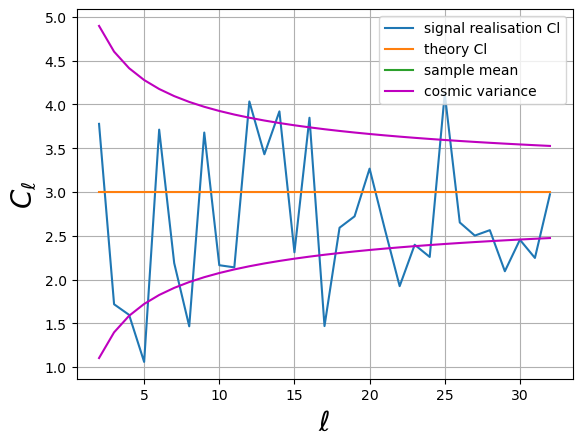

In [20]:
#plot the summary statistics
burnin = 1000
elmin = 2
plt.plot(el[elmin:], data_cl[elmin:], label = 'signal realisation Cl')
plt.plot(el[elmin:], Cl_th[elmin:], label = 'theory Cl')
#plt.plot(el[elmin:], np.mean(sample_q_cl[burnin:,elmin:]*(2.0*el[elmin:]+1)/(2.0*el[elmin:]+2), axis=0) )
plt.plot(el[elmin:], np.mean(sample_q_cl[burnin:,elmin:], axis=0), label = 'sample mean')
plt.plot(el[elmin:], Cl_th[2:] + Cl_th[2:]*np.sqrt(2.0/(2*el[elmin:]+1.0)), 
         color = 'm', label =  'cosmic variance')
plt.plot(el[elmin:], Cl_th[2:] - Cl_th[2:]*np.sqrt(2.0/(2*el[elmin:]+1.0)), 
         color = 'm' )
plt.grid()
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)
plt.legend(loc = 'upper right')

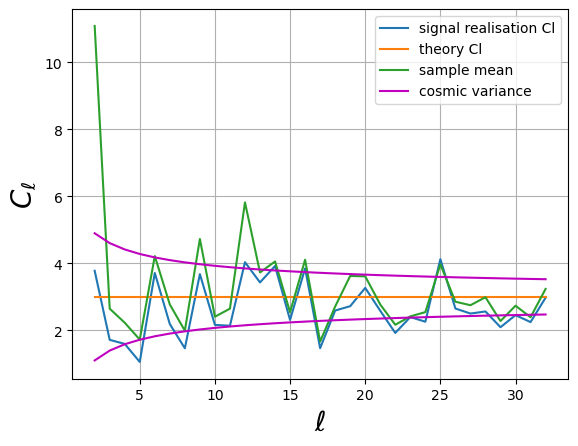

In [30]:
#plot the summary statistics
burnin = 10
elmin = 2
plt.plot(el[elmin:], data_cl[elmin:], label = 'signal realisation Cl')
plt.plot(el[elmin:], Cl_th[elmin:], label = 'theory Cl')
#plt.plot(el[elmin:], np.mean(sample_q_cl[burnin:,elmin:]*(2.0*el[elmin:]+1)/(2.0*el[elmin:]+2), axis=0) )
plt.plot(el[elmin:], np.mean(sample_q_cl[burnin:,elmin:], axis=0), label = 'sample mean')
plt.plot(el[elmin:], Cl_th[2:] + Cl_th[2:]*np.sqrt(2.0/(2*el[elmin:]+1.0)), 
         color = 'm', label =  'cosmic variance')
plt.plot(el[elmin:], Cl_th[2:] - Cl_th[2:]*np.sqrt(2.0/(2*el[elmin:]+1.0)), 
         color = 'm' )
plt.grid()
plt.xlabel(r'$\ell$', fontsize = 20)
plt.ylabel(r'$C_{\ell}$', fontsize = 20)
plt.legend(loc = 'upper right')

In [27]:
np.mean(sample_q_cl[burnin:,elmin:], axis=0)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan])

In [28]:
sample_q_cl[burnin:,elmin:]

array([], shape=(0, 31), dtype=float64)